# Self-organising maps

Let's use some self-organising maps to arrange our waterbodies.

## Setup

### Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.optimize as opt
import matplotlib.colors
from tqdm.notebook import tqdm
import sklearn.cluster
import sklearn.decomposition
import sompy
import scipy.ndimage.filters
import matplotlib.animation

%matplotlib widget

Loaded backend module://ipympl.backend_nbagg version unknown.


### Load the data

This was generated in WaterbodyClustering.ipynb.

In [2]:
history = np.load('history_murray_full_norivers.npy')
times = np.load('time_axis_murray_full_norivers.npy').astype('datetime64[D]')
waterbodies = gpd.read_file('waterbodies_murray_norivers.geojson')

Entering env context: <fiona.env.Env object at 0x7fc973cd0048>
Starting outermost env
No GDAL environment exists
New GDAL environment <fiona._env.GDALEnv object at 0x7fc962be3940> created
Logging error handler pushed.
All drivers registered.
GDAL_DATA found in environment: '/g/data/v10/public/modules/dea-env/20200713/share/gdal'.
PROJ_LIB found in environment: '/g/data/v10/public/modules/dea-env/20200713/share/proj'.
Started GDALEnv <fiona._env.GDALEnv object at 0x7fc962be3940>.
Updated existing <fiona._env.GDALEnv object at 0x7fc962be3940> with options {}
Entered env context: <fiona.env.Env object at 0x7fc973cd0048>
Got coordinate system
Index: 0
Flushed buffer
Stopped session
Exiting env context: <fiona.env.Env object at 0x7fc973cd0048>
Cleared existing <fiona._env.GDALEnv object at 0x7fc962be3940> options
Stopping GDALEnv <fiona._env.GDALEnv object at 0x7fc962be3940>.
Error handler popped.
Stopped GDALEnv <fiona._env.GDALEnv object at 0x7fc962be3940>.
Exiting outermost env
Exited en

## Vector self-organising maps

As nice as it would be to use something designed for time series, most SOMs work on vector data. To get around this, we'll Gaussian blur the vector data &mdash; this is similar to a kernel and imposes correlations between neighbouring time stamps. This means that it imposes _structure_ on the vector, like a budget time series method. We'll also only use the last five years of data to ignore long-term effects (e.g. many water bodies didn't exist at the start of our data!).

In [3]:
data = history[:, -365 * 5:]

In [4]:
blurred_data = scipy.ndimage.filters.gaussian_filter1d(data, 7, axis=1)

In [5]:
k = 20
plt.figure()
plt.plot(times[-365 * 5:], data[k])
plt.plot(times[-365 * 5:], blurred_data[k])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We'll use SOMPY for generating the map.

In [105]:
mapsize = [50, 50]
som = sompy.SOMFactory.build(
    blurred_data,
    mapsize)
som.train(n_job=4, verbose='debug')  # verbose='debug' will print more, and verbose=None wont print anything

 Training...
--------------------------------------------------------------
 details: 
      > data len is 9081 and data dimension is 1825
      > map size is 50,50
      > array size in log10 scale is 10.617336553140767
      > number of jobs in parallel: 4
 -------------------------------------------------------------

 pca_linear_initialization took: 1.103000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 9

 find_bmu took: 1.460000 seconds
 update_codebook_voronoi took: 0.840000 seconds
 epoch: 1 ---> elapsed time:  2.536000, quantization error: 26.397222

 find_bmu took: 1.360000 seconds
 update_codebook_voronoi took: 0.682000 seconds
 epoch: 2 ---> elapsed time:  2.398000, quantization error: 31.810184

 find_bmu took: 1.576000 seconds
 update_codebook_voronoi took: 0.321000 seconds
 epoch: 3 ---> elapsed time:  2.119000, quantization error: 23.401697

 find_bmu took: 1.348000 seconds
 update_codebook_voronoi took: 0.691000 seconds
 epoch: 4 

In [106]:
um = sompy.umatrix.UMatrixView(10, 10, 'umatrix', show_axis=True, text_size=8, show_text=True)
umat = um.build_u_matrix(som, distance=1, row_normalized=False)
UMAT = um.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

There are some weak clusters in the U-matrix, but it looks like most of the data is up in that upper-right corner.

In [110]:
def get_anim():
    # need a closure for these variables
    fig = plt.figure()
    codebook = som.codebook.matrix.reshape(tuple(mapsize) + (-1,))
    ax = fig.add_subplot(2, 1, 1)
    im = ax.imshow(codebook[:, :, 0])
    ax = fig.add_subplot(2, 1, 2)
    mean = blurred_data.mean(axis=0)
    ax.plot(times[-365 * 5:], mean, c='k')
    line = ax.axvline(times[-365 * 5], c='r')
    def update_im(i):
        i = i * 5
        im.set_data(codebook[:, :, i])
        t = times[-365 * 5 + i]
        line.set_xdata([t, t])
    anim = matplotlib.animation.FuncAnimation(fig, update_im, frames=range(365), interval=10)
    return anim

anim = get_anim()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
anim.save('som_animation.gif', writer='imagemagick', fps=60)

Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
frame size in pixels is 640 x 480
MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 1.6666666666666667 -loop 0 rgba:- som_animation.gif
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter.grab_frame: Grabbing frame.
MovieWriter

In [111]:
cl = som.cluster()

In [113]:
plt.figure()
plt.imshow(cl.reshape(mapsize), cmap='rainbow')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [114]:
bmus = som.find_bmu(blurred_data, njb=4)

 find_bmu took: 1.563000 seconds


In [115]:
clusters = cl[bmus[0].astype(int)]

In [117]:
max(clusters)

7

In [116]:
plt.figure()
for cluster in range(8):
    plt.subplot(4, 2, cluster + 1)
    plt.plot(times[-365 * 5:], blurred_data[clusters == cluster].mean(axis=0), c='k')
    if (clusters == cluster).any():
        plt.plot(times[-365 * 5:], blurred_data[clusters == cluster][:100].T, alpha=0.01, c='b')
    plt.title('Cluster {} (n = {})'.format(cluster, sum(clusters == cluster)))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Finally, some of these clusters actually look meaningful. Not all of them by any means, but two clusters both look pretty good (and pretty similar). What are these?

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
waterbodies[clusters == 1].to_crs('EPSG:3857').plot(ax=ax, color='red')
waterbodies[clusters == 6].to_crs('EPSG:3857').plot(ax=ax, color='red')
import contextily as ctx
ctx.add_basemap(ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

These seem to be natural waterbodies that flooded during La Ninas and were dry otherwise. They even look pretty similar before the last five years:
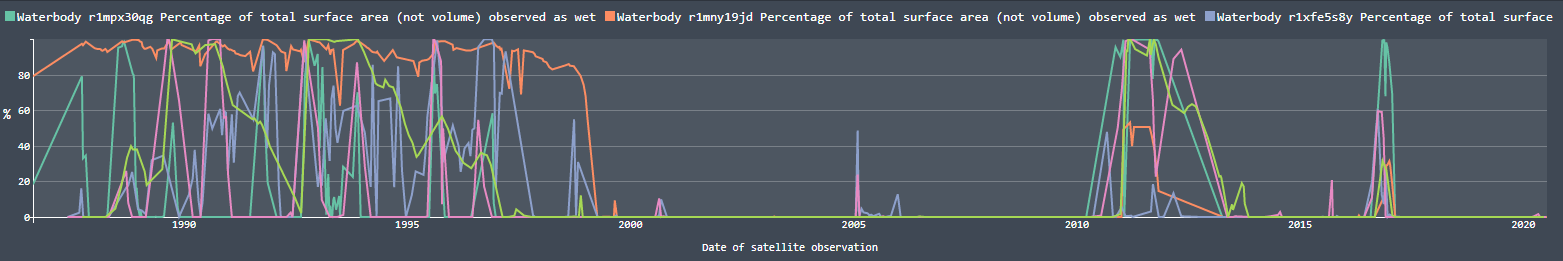

But this doesn't really use the map. Let's project onto the map...

In [118]:
proj = som.node_activation(blurred_data)

In [119]:
proj_ = np.array([vals[np.argsort(nodes)] for vals, nodes in zip(*proj)])

Then we'll cluster that with k-means.

In [120]:
kmc = sklearn.cluster.KMeans(n_clusters=8)

In [121]:
clusters = kmc.fit_predict(proj_)

In [122]:
cluster_memberships = np.zeros((kmc.n_clusters, np.product(mapsize)))
for cluster in range(kmc.n_clusters):
    cluster_memberships[cluster] = proj_[clusters == cluster].mean(axis=0)

In [123]:
plt.figure()
for i in range(kmc.n_clusters):
    plt.subplot(2, 4, i + 1)
    plt.imshow(cluster_memberships[i].reshape(mapsize))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Not great! But maybe they're good? Let's look at the averages again.

In [124]:
plt.figure()
for cluster in range(8):
    plt.subplot(4, 2, cluster + 1)
    plt.plot(times[-365 * 5:], blurred_data[clusters == cluster].mean(axis=0), c='k')
    if (clusters == cluster).any():
        plt.plot(times[-365 * 5:], blurred_data[clusters == cluster][:100].T, alpha=0.01, c='b')
    plt.title('Cluster {} (n = {})'.format(cluster, sum(clusters == cluster)))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

These are pretty meaningless. :(